# Exercices de découverte du PMSI MCO 2 (_Version Python_)
Bienvenue sur ce notebook d'introduction à la manipulation des diagnostics hospitaliers dans le PMSI ! L'objectif est de vous accompagner, grâce à une manipulation guidée, dans l’identification simplifiée des diagnostics hospitaliers dans les tables du PMSI MCO (Médecine-Obstétrique-Chirurgie). Des diagnostics hospitaliers sont également identifiables dans les champs HAD (Hospitalisation à domicile), SSR (Soins de suite et réadaptation) et RIM-P (Psychiatrie) du PMSI selon des procédures semblables mais nous ne travaillerons pas sur ces champs.

Vous trouverez le schéma des concepts de fonctionnement du PMSI et l'articulation de ses principales bases sur la [fiche dédiée](https://documentation-snds.health-data-hub.fr/fiches/concepts_PMSI.html#pmsi-mco). Ces quelques exercices sont conçus pour vous accompagner dans la manipulation des données du PMSI et vous familiariser avec leur structure à l'aide de données fictives.

L’ objectif est d’analyser le profil (en termes d’âge et de sexe) des patients avec un diagnostic hospitalier d'écoulement du liquide céphalorachidien (ELCR) dans le PMSI MCO.

**A noter que les données utilisées pour le développement de ce notebook sont des données synthétiques avec les mêmes formats et types des valeurs des données réelles du SNDS. Il s'agit de données fictives générées aléatoirement, qui ne sont pas nécessairement plausibles et ne recouvrent pas une réalité médicale. Ces données ont été générées par le Lab Santé de la DREES.**

Pour plus d'information sur ces données, vous pouvez consulter la [page dédiée sur le site de documentation du SNDS](https://documentation-snds.health-data-hub.fr/ressources/donnees_synthetiques.html#ou-trouver-le-snds-synthetique).

# Préambule : Les diagnostics hospitaliers dans le PMSI
Les diagnostics hospitaliers sont codés selon la 10e version de la classification internationale des maladies [CIM10](https://documentation-snds.health-data-hub.fr/glossaire/cim.html). Un [moteur de recherche pour consulter la CIM10](https://icd.who.int/browse10/2008/fr) se trouve sur le site de l'Organisaton Mondiale de la Santé. Vous pouvez trouver la nomenclature associée `MS_CIM_V` utilisée dans la SNDS sur le [dictionnaire intéractif](https://drees.shinyapps.io/dico-snds/). 

Il existe trois types de diagnostics hospitaliers :
-	Le **diagnostic principal (DP)** :  Problème de santé qui, **a posteriori**, a motivé l’admission du patient dans l’UM. Si plusieurs possibles, c’est celui qui a mobilisé l’essentiel de l’effort de soins.
-	Le **diagnostic relié (DR)** : Facultatif, seulement quand le DP est un code Z (pas une maladie mais un code type « soins palliatifs », « surveillance », « bilan » etc.). Le DR est dans ce cas la maladie qui explique le DP.
-	Le **diagnostic associé (DA)** : Comprend les comorbidités associées au DP. Les DA documentaires (maladies n’ayant pas modifié la prise en charge) ne sont pas renseignés dans le PMSI ; seuls les DA significatifs le sont.

Les diagnostics hospitaliers identifiés dans ces exercices concernent le séjour de manière globale et non le détail des diagnostics établis dans chaque unité médicale (UM). 

En effet, lors d’un séjour hospitalier, le patient peut passer par différentes unités médicales qui établissent chacune leurs DP, DR et DA spécifiques. A la fin du séjour, les informations des différents résumés d’unité médicale (RUM) sont groupées dans un résumé de sortie anonymisé (RSA). Dans le processus de groupage, un DP et un DR parmi l'ensemble des DP et DR des RUM seront retenus pour le RSA. La majorité des autres diagnostics non retenus comme DP ou DR du RSA seront considérés comme DA. Pour avoir une vision exhaustive des diagnostics établis - ce qui ne sera pas le cas dans les exercices - il est conseillé de travailler à partir de la table des RUM (`T_MCOaaUM`).

# Préparation et configuration
Commençons importer le module **pandas** contenant des fonctions dont nous nous servirons dans les exercices.

In [2]:
#chargement des modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path

Importons maintenant les données synthétiques sur lesquelles nous allons exécuter les exercices.

/!\ Attention, les données synthétiques ne correspondent pas à une période temporelle donnée. Cela est toutefois le cas dans le SNDS où la plupart des tables du PMSI sont annuelles. **Il faut retenir que les bases annuelles du PMSI dans le vrai SNDS ne contiennent que les séjours s’étant terminés pendant l’année.**

In [3]:
# Chemins d'accès aux fichiers
DATA_DIR = os.path.abspath("../data/")              # Dossier où sont stockées les données

T_MCO_B_FILE = os.path.join(DATA_DIR, "T_MCOaa_nnB.csv")    # MCO - Description du séjour
T_MCO_C_FILE = os.path.join(DATA_DIR, "T_MCOaa_nnC.csv")    # MCO - Pseudonymes des patients et dates de soin
T_MCO_D_FILE = os.path.join(DATA_DIR, "T_MCOaa_nnD.csv")    # MCO - Diagnostics associés

In [ ]:
# Récupération des fichiers de données depuis Gitlab
# Cette étape est optionnelle si les données sont déjà présentes (par exemple si vous avez cloné tout le dossier Gitlab)

import urllib.request               # Téléchargement de fichiers

GITLAB_DATA_URL = "https://gitlab.com/healthdatahub/formation/exercices-snds/-/raw/master/data/"

urllib.request.urlretrieve(GITLAB_DATA_URL + "T_MCOaa_nnB.csv", T_MCO_B_FILE)
urllib.request.urlretrieve(GITLAB_DATA_URL + "T_MCOaa_nnC.csv", T_MCO_C_FILE)
urllib.request.urlretrieve(GITLAB_DATA_URL + "T_MCOaa_nnD.csv", T_MCO_D_FILE)

In [6]:
# Import des données
T_MCOaa_nnB = pd.read_csv(T_MCO_B_FILE, sep=",",header=0)           # Description séjour
T_MCOaa_nnC = pd.read_csv(T_MCO_C_FILE, sep=",",header=0)           # NIR patient et dates
T_MCOaa_nnD = pd.read_csv(T_MCO_D_FILE, sep=",",header=0)           # Diagnostics associés

On prépare les vecteurs dont nous aurons besoin :

-	**Les doublons d'établissements de soins à supprimer** : Dans le SNDS, des nettoyages sont nécessaires pour la bonne exploitation des données. Au niveau du PMSI, l'un d'entre eux consiste à supprimer les doublons au niveau de certains établissements de soins grâce à leur numéro FINESS. En effet, pour l’APHP (Assistance Publique - Hôpitaux de Paris), les HCL (Hospices Civils de Lyon) et l’APHM (Hôpitaux Universitaires de Marseille), les établissements sont présents à la fois sous leur code FINESS géographique et juridique (jusqu’en 2018). Afin de ne pas les compter en double, il faut supprimer un certain nombre de codes grâce à la variable `ETA_NUM` renseignant le code FINESS des établissements. Vous trouverez ci-dessous un vecteur *eta_num_supr* avec les codes ETA_NUM à supprimer lorsqu'on travaille sur le PMSI (cf. [Fiche Dépenses des établissements de santé publics dans le PMSI](https://documentation-snds.health-data-hub.fr/fiches/depenses_hopital_public.html#valorisation-des-sejours-a-l-hopital-public)).

In [7]:
# ETA_NUM doubles à supprimer
eta_num_supr = ['130780521','130783236', '130783293', '130784234', '130804297', '600100101','750041543', '750100018',
                '750100042', '750100075', '750100083', '750100091', '750100109', '750100125','750100166', '750100208', 
                '750100216', '750100232', '750100273', '750100299', '750801441', '750803447','750803454', '910100015', 
                '910100023', '920100013', '920100021', '920100039', '920100047', '920100054','920100062', '930100011', 
                '930100037', '930100045', '940100027', '940100035', '940100043', '940100050','940100068', '950100016', 
                '690783154', '690784137', '690784152', '690784178', '690787478', '830100558']

- **Les codes CIM10 pour identifier la pathologie recherchée**, ici l’écoulement céphalorachidien (ELCR) :
    - G96 : Ecoulement du liquide céphalorachidien
    - G970 : Ecoulement du liquide céphalorachidien après rachicentèse

In [8]:
# Code diagnostics CIM10 recherchés
diag_cim10 = ["G96", "G970"]

# Exercice 1 : Récupération des séjours avec des diagnostics comportant les codes CIM10 recherchés (ELCR)
Le DP et DR du séjour hospitalier sont respectivement stockés dans les variables `DGN_PAL` et `DGN_REL` et se trouvent dans la table des séjours `T_MCOaaB`. Le séjour possède toujours un unique DP ; le DR est optionnel et est unique aussi pour le séjour.
Un séjour hospitalier est identifié par le couple `ETA_NUM` (numéro FINESS de l’établissement de soins) et `RSA_NUM` (numéro du résumé de sortie anonymisé). Ces deux variables servent de clés de jointure au sein du PMSI MCO. La table `T_MCOaaB` contient également les caractéristiques démographiques du patient (âge : `AGE_ANN`, sexe : `COD_SEX`) mais pas le pseudonyme patient, ni les dates de séjour.

In [9]:
# Récupération des diagnostics principaux et reliés dans T_MCOaaB
filtres_mco_b =  (T_MCOaa_nnB['DGN_PAL'].str.startswith(("G96","G970")) 
                  | T_MCOaa_nnB['DGN_REL'].str.startswith(("G96","G970"))
                 &  (~T_MCOaa_nnB['ETA_NUM'].isin(eta_num_supr))
                 & (~T_MCOaa_nnB['GRG_GHM'].str.startswith('90')))

diag_princ_rel = T_MCOaa_nnB[['ETA_NUM', 'RSA_NUM', 'GRG_GHM', 'SEJ_NBJ', 'DGN_PAL', 'DGN_REL', 'AGE_ANN', 'COD_SEX']] [filtres_mco_b]
  

diag_princ_rel.head(6)

ETA_NUM     RSA_NUM GRG_GHM  SEJ_NBJ DGN_PAL DGN_REL  AGE_ANN  COD_SEX
32   514568961  4797034198  JOwHbb     2556    G970   F2011       40        1
75   545311862  9954230169  nMJPyP     2635    F319    G970       14        7
173  751735449  7852887004  vsstTg      463    G969    F428       19        1
276  574597472  7923868566  pgJelh     2841    G969    F318      117        2
324  879549206  7688485884  hIkabI     1495    G970   F2041        8        1
350  602191672  5648433194  WCYobW      133   F4480    G969        9        7

Les DA du séjour hospitalier sont stockés dans la variable `ASS_DGN` qui se trouve dans la table `T_MCOaaD`. Contrairement au DP et DR, un séjour peut posséder plusieurs DA. Pour information, Le nombre de DA renseignés pour un séjour donné (couple `ETA_NUM`, `RSA_NUM`) est stocké dans la variable `DGN_ASS_NUM` dans la même table. 

In [10]:
# Récupération des diagnostics associés dans T_MCOaaD (plusieurs DA par séjour/patient possible)
diag_ass = T_MCOaa_nnD[T_MCOaa_nnD['ASS_DGN'].str.startswith(("G96","G970"))]

diag_ass.head(6)

ASS_DGN  DGN_ASS_NUM    ETA_NUM     RSA_NUM RSS_NUM
161    G969         7404  392381480  1520653005     NaN
339    G969         8727  863007477  1716226784     NaN
356    G970          481  513072894  2479454372       Z
527    G970         3484  548324595  2195896160       T
535    G970           54  580144897  7531156073       B
782    G970         1051  863007477  6525685393      tt

Pour récupérer les caractéristiques démographiques du patient, il faut réaliser une jointure entre l’extraction de la table `T_MCOaaD` et la table `T_MCOaaB` grâce aux clés de jointure du PMSI MCO : `ETA_NUM` et `RSA_NUM`.
Par ailleurs, il est d'usage de supprimer les séjours dits « en erreur » (deux premiers caractères de `GRG_GHM` différents de '90').
Ces séjours sont : 
- soit des séjours qui contiennent des informations manquantes (diagnostics, âge, date de sortie, etc.) qui ne permettent pas de grouper le séjour (algorithme de groupage) et de lui attribuer un tarif
- soit ce sont de « faux » séjours générés automatiquement pour des besoins de facturation (dialyse, activité externe, etc...) des établissements privés.

In [11]:
# On ne garde que les DA des séjours qui ne sont pas codés en erreur + récupération de l'âge et du sexe des patients avec un DA
# à partir de la table T_MCOaaB
T_MCOaa_nnB_tojoin = T_MCOaa_nnB[['ETA_NUM', 'RSA_NUM', 'GRG_GHM', 'SEJ_NBJ', 'DGN_PAL', 'DGN_REL', 'AGE_ANN', 'COD_SEX']][
                      (~T_MCOaa_nnB['ETA_NUM'].isin(eta_num_supr))
                      & (~T_MCOaa_nnB['GRG_GHM'].str.startswith('90'))]

diag_ass2 = diag_ass.merge(T_MCOaa_nnB_tojoin,
                          how = 'left',
                          on=["ETA_NUM", "RSA_NUM"])

On compile ensuite les données :

In [12]:
# Regroupement des DP, DR, DA de ELCR
diag_princ_rel_ass = diag_princ_rel.append(diag_ass2)

diag_princ_rel_ass.head(6)

ETA_NUM     RSA_NUM GRG_GHM  SEJ_NBJ DGN_PAL DGN_REL  AGE_ANN  COD_SEX  \
32   514568961  4797034198  JOwHbb     2556    G970   F2011       40        1   
75   545311862  9954230169  nMJPyP     2635    F319    G970       14        7   
173  751735449  7852887004  vsstTg      463    G969    F428       19        1   
276  574597472  7923868566  pgJelh     2841    G969    F318      117        2   
324  879549206  7688485884  hIkabI     1495    G970   F2041        8        1   
350  602191672  5648433194  WCYobW      133   F4480    G969        9        7   

    ASS_DGN  DGN_ASS_NUM RSS_NUM  
32      NaN          NaN     NaN  
75      NaN          NaN     NaN  
173     NaN          NaN     NaN  
276     NaN          NaN     NaN  
324     NaN          NaN     NaN  
350     NaN          NaN     NaN

# Exercice 2 : Récupérer le pseudonyme patient et les dates de séjour associés au séjour avec un diagnostic de ELCR

Nous venons de récupérer les diagnostics hospitaliers des séjours dans les tables `T_MCOaaB` et `T_MCOaaD`. Toutefois, ces tables ne contiennent pas l’information sur le pseudonyme patient, ni sur les dates de séjour. Ces informations sont à récupérer dans la table `T_MCOaaC` en utilisant les clés de jointure du PMSI MCO : `ETA_NUM` et `RSA_NUM`.

Le pseudonyme patient est stocké dans la variable `NIR_ANO_17`. Pour information, cette variable s’appelle `BEN_NIR_PSA` dans les tables du DCIR.

La date de début et de fin de séjour sont respectivement stockées dans les variables `EXE_SOI_DTD` et `EXE_SOI_DTF`.

NB : Les données utilisées dans ce notebook étant générées aléatoirement, il est possible qu'il y ait des incohérences dans les données. Ainsi, dans ces données, on peut trouver un séjour (`ETA_NUM` + `RSA_NUM`) associé à plusieurs personnes (`NIR_ANO_17`) alors que cela n’est pas possible dans le vrai SNDS. Une opération de mise en cohérence des données `T_MCOaaC` est donc nécessaire ici mais cette action n'est pas à faire lorsqu'on travaille sur un jeu de données réelles.

In [13]:
# Mise en cohérence de la table T_MCOaaC
T_MCOaa_nnC2 = T_MCOaa_nnC.groupby(['ETA_NUM', 'RSA_NUM']).nth(0).reset_index()

On réalise une jointure avec la table `T_MCOaaC` mise en cohérence grâce aux clés de jointure `ETA_NUM` et `RSA_NUM` pour récupérer le pseudonyme patient et les dates de séjour.

In [14]:
# Fusion avec la table T_MCOaaC pour recuperer le pseudonyme et les dates du sejour
patient_diag_ecr = diag_princ_rel_ass.merge(T_MCOaa_nnC2[["ETA_NUM","RSA_NUM", "NIR_ANO_17", "EXE_SOI_DTD","EXE_SOI_DTF"]],
                                            on=["ETA_NUM","RSA_NUM"],
                                            how="inner")

Dans l’éventualité où une personne peut avoir été hospitalisée plusieurs fois avec un diagnostic d’ELCR, il faut penser à ne garder qu'un seul évènement par patient. Ici, dans le cas de doublons de `NIR_ANO_17`, on garde les informations associées à la date de séjour (date de sortie : `EXE_SOI_DTF`) la plus ancienne.

In [22]:
# On garde, pour chaque patient avec un diagnostic d'ELCR, les informations récoltées lors de la date d'hospitalisation la plus ancienne
patient_diag_ecr["EXE_SOI_DTF"] = pd.to_datetime(patient_diag_ecr["EXE_SOI_DTF"],format="%d%b%Y:%H:%M:%S")
patient_diag_ecr["diag_date"] = patient_diag_ecr["EXE_SOI_DTF"].dt.ceil(freq="d")
patient_prem_diag = patient_diag_ecr.iloc[patient_diag_ecr.groupby("NIR_ANO_17")["EXE_SOI_DTF"].idxmin()].copy()

patient_prem_diag.head(6)

ETA_NUM     RSA_NUM GRG_GHM  SEJ_NBJ DGN_PAL DGN_REL  AGE_ANN  COD_SEX  \
23  378917557  6804151999  ZkuvQr      945    F315   F2054       77        7   
6   513072894  2479454372  CzUkPb     1891    F340     F45       74        9   
30  353179027  4290380042  JGhgFO     1521     G97   F3231      103        9   
45  328721423  2406319896  UbryTq     1967   F2014    F199       94        7   
2   545311862  9954230169  nMJPyP     2635    F319    G970       14        7   
26  499551820  9238886713  RZMjSW      974    F508    F443       29        9   

   ASS_DGN  DGN_ASS_NUM RSS_NUM         NIR_ANO_17         EXE_SOI_DTD  \
23    G970       9199.0     Zef  CzJZPUuvpcjRBsifl  28Jul1948:08:34:29   
6     G970        481.0       Z  EZYHWLIARxwkPaoaj  09May2010:16:28:00   
30    G969       5155.0     rtQ  FVYAxMnVimyPuWvZg  02Jan1940:11:15:40   
45    G969       3071.0       C  GqEqrRoaMOJLQbIcq  25Jun2006:21:56:20   
2      NaN          NaN     NaN  IgunKBglVOVNmmNpj  30Jun1996:15:38:22   
26    G970       3642.0      Wj  KnRbKoiJGkhzzJzeO  19Jun1949:16:42:04   

           EXE_SOI_DTF  diag_date  
23 2011-07-10 22:02:39 2011-07-11  
6  1934-05-12 15:23:11 1934-05-13  
30 1954-07-06 00:46:10 1954-07-07  
45 2021-01-23 20:04:48 2021-01-24  
2  1916-09-02 12:22:55 1916-09-03  
26 1973-10-22 20:41:02 1973-10-23

# Exercice 3 : Statistiques descriptives et graphique

On crée les classes d'âge et on change le codage du sexe :

In [23]:
# Classes d'âge
bins = [0,18,25,30,40,50,60,70,80,90,np.inf]
age_classes = ["[0-17]","[18-24]","[25-29]","[30-39]","[40-49]","[50-59]","[60-69]","[70-79]","[80-89]","[90+]"]
patient_prem_diag['AGE_CAT'] = pd.cut(patient_prem_diag['AGE_ANN'],bins=bins,labels=age_classes,right=False)

In [24]:
# Recodage du sexe
mapping = {1:"Hommes",2:"Femmes",0:"Inconnu",7:"Inconnu",8:"Inconnu",9:"Inconnu"}
patient_prem_diag["COD_SEX"] = patient_prem_diag["COD_SEX"].map(mapping)

Tableau de fréquence par sexe des patients :

In [25]:
# Tableau de fréquence en nombre d'observations
print("Tableau de fréquence par sexe en nombre d'observations :")
print(patient_prem_diag["COD_SEX"].value_counts().to_frame().T)

# Tableau de fréquence en pourcentage d'observations
print("Tableau de fréquence par sexe en pourcentage d'observations :")
print((100*patient_prem_diag["COD_SEX"].value_counts(normalize=True)).to_frame().T.round(1))

Tableau de fréquence par sexe en nombre d'observations :
         Inconnu  Femmes  Hommes
COD_SEX       25       7       4
Tableau de fréquence par sexe en pourcentage d'observations :
         Inconnu  Femmes  Hommes
COD_SEX     69.4    19.4    11.1


On calcule les distributions d’âge suivant les différentes strates de sexe :

In [26]:
# Distribution âge ensemble
print("Distribution âge de l'ensemble des patients :")
print(patient_prem_diag["AGE_ANN"].describe().drop(['count','mean','std']).to_frame().T)
print(f"L'âge moyen est de : {patient_prem_diag['AGE_ANN'].mean():.0f} ans")

# Distribution âge hommes
print("\nDistribution âge des patients hommes :")
print(patient_prem_diag[patient_prem_diag["COD_SEX"]=="Hommes"]["AGE_ANN"].describe().drop(['count','mean','std']).to_frame().T)
print(f"L'âge moyen est de : {patient_prem_diag[patient_prem_diag['COD_SEX']=='Hommes']['AGE_ANN'].mean():.0f} ans")

# Distribution âge femmes
print("\nDistribution âge des patients femmes :")
print(patient_prem_diag[patient_prem_diag["COD_SEX"]=="Femmes"]["AGE_ANN"].describe().drop(['count','mean','std']).to_frame().T)
print(f"L'âge moyen est de : {patient_prem_diag[patient_prem_diag['COD_SEX']=='Femmes']['AGE_ANN'].mean():.0f} ans")

# Distribution âge sexe inconnu
print("\nDistribution âge des patients avec sexe inconnu :")
print(patient_prem_diag[patient_prem_diag["COD_SEX"]=="Inconnu"]["AGE_ANN"].describe().drop(['count','mean','std']).to_frame().T)
print(f"L'âge moyen est de : {patient_prem_diag[patient_prem_diag['COD_SEX']=='Inconnu']['AGE_ANN'].mean():.0f} ans")

# Distribution des catégories d'âge
print("\nTableau de fréquence par âge catégorisé en nombre d'observations :")
print(patient_prem_diag["AGE_CAT"].value_counts().to_frame().T[age_classes])

print("\nTableau de fréquence par âge catégorisé en pourcentage d'observations :")
print((100*patient_prem_diag["AGE_CAT"].value_counts(normalize=True)).to_frame().T.round(1)[age_classes])

Distribution âge de l'ensemble des patients :
         min   25%   50%   75%    max
AGE_ANN  8.0  28.5  53.5  80.5  107.0
L'âge moyen est de : 56 ans

Distribution âge des patients hommes :
          min    25%   50%   75%    max
AGE_ANN  14.0  17.75  58.0  99.5  107.0
L'âge moyen est de : 59 ans

Distribution âge des patients femmes :
          min   25%   50%    75%    max
AGE_ANN  23.0  49.0  70.0  101.5  106.0
L'âge moyen est de : 71 ans

Distribution âge des patients avec sexe inconnu :
         min   25%   50%   75%    max
AGE_ANN  8.0  29.0  47.0  74.0  103.0
L'âge moyen est de : 52 ans

Tableau de fréquence par âge catégorisé en nombre d'observations :
         [0-17]  [18-24]  [25-29]  [30-39]  [40-49]  [50-59]  [60-69]  \
AGE_CAT       5        2        3        1        6        5        0   

         [70-79]  [80-89]  [90+]  
AGE_CAT        5        1      8  

Tableau de fréquence par âge catégorisé en pourcentage d'observations :
         [0-17]  [18-24]  [25-29]  [30-39

On représente les distribution par âge et sexe sous forme de graphique (histogramme) :

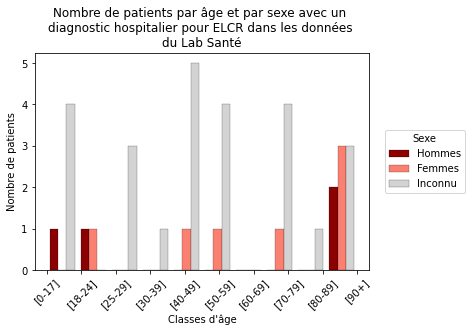

In [27]:
genders = ["Hommes","Femmes","Inconnu"]
#astuce pour garder l'ordre des classes d'âge
age_cat_mapping = {ac:i for i,ac in enumerate(age_classes)}
patient_prem_diag.loc[:,'AGE_CAT_NO'] = patient_prem_diag['AGE_CAT'].copy().map(age_cat_mapping)

plt.hist([patient_prem_diag.loc[patient_prem_diag.COD_SEX == x, "AGE_CAT_NO"] for x in genders],
         label=genders,color=["darkred","salmon","lightgrey"],edgecolor="k",linewidth=.2)
plt.title("Nombre de patients par âge et par sexe avec un \ndiagnostic hospitalier pour ELCR dans les données \ndu Lab Santé",fontsize=12)
plt.xlabel("Classes d'âge",fontsize=10)
plt.xticks(range(len(age_classes)),age_classes,rotation=45)
plt.ylabel("Nombre de patients",fontsize=10)
plt.legend(title="Sexe",loc="center right",bbox_to_anchor=(1.3,0.5))
plt.show()